# Mini scGPT - A (small) foundation model for single-cell mouse data

Inspired from https://www.nature.com/articles/s41592-024-02201-0 (Cui et al. 2024)

In [3]:
import numpy as np
import scanpy as sc

import os
import sys

from typing import Tuple

In [4]:
DPATH = '/home/risitop/Code/small-scgpt/data'
sys.path.append(DPATH)

# Data loading
fname = "tabmuris_A.h5ad"
adata = sc.read_h5ad(os.path.join(DPATH, fname))
adata = adata[np.logical_not(adata.obs['Cell type'].isna())].copy()
adata.var_names = adata.var_names.str.upper()

In [5]:
# Quick data preprocessing
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=500)
adata = adata[:, adata.var['highly_variable']].copy()
sc.pp.filter_cells(adata, min_counts=10)

/home/risitop/.local/share/virtualenvs/small-scgpt-B3Bl7c42/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [6]:
# Counts binning (see https://www.nature.com/articles/s41592-024-02201-0)
import numpy as np
from scipy.sparse import csr_matrix

N_BINS = 10

def bin_array(x: np.ndarray, nbins: int = 10) -> np.ndarray:
    """Applies cell-wise value-binning to a count matrix."""
    d = x.shape[1]
    ix_sorted = np.argsort(x, axis=-1)
    binned_x = np.zeros(x.shape, dtype=int)
    for cix, gix in enumerate(ix_sorted):
      values = x[cix]
      values_ord = x[cix, gix]
      nnz = (values > 0).sum()
      nz = d - nnz
      step = nnz / nbins
      for i in range(nbins):
        thr = values_ord[nz + int(step * i)]
        binned_x[cix, gix[values >= thr]] = i + 1
    return binned_x

if not isinstance(adata.X, np.ndarray):
  adata.X = adata.X.toarray()
adata.obsm['X_binned'] = bin_array(adata.X, nbins=N_BINS)

In [7]:
# Defining gene and cell types vocabulary
PAD_TOKEN = '<pad>'
special_tokens = [PAD_TOKEN]
vocab = list(sorted([g for g in adata.var_names])) + [PAD_TOKEN] # 1 gene name = 1 token

VOCAB_SIZE = len(vocab)

ctypes = sorted(set(adata.obs['Cell type']))
N_TYPES = len(ctypes)

gtoi = {g: i for i, g in enumerate(vocab)}
itog = {i: g for i, g in enumerate(vocab)}

ctoi = {c: i for i, c in enumerate(ctypes)}
itoc = {i: c for i, c in enumerate(ctypes)}

In [8]:
# Data handling
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
INPUT_SIZE = VOCAB_SIZE - 1

X = adata[:, vocab[:-1]].obsm['X_binned']

split = np.random.random((adata.n_obs,)) < 0.9
train_data, val_data = X[split], X[np.logical_not(split)]
train_targets, val_targets = adata[:, vocab[:-1]].X[split], adata[:, vocab[:-1]].X[np.logical_not(split)]
train_ctype, val_ctype = [ctoi[c] for c in adata[split].obs['Cell type']], [ctoi[c] for c in adata[split].obs['Cell type']]

train_data, val_data = torch.tensor(train_data).type(torch.long), torch.tensor(val_data).type(torch.long)
train_targets, val_targets = torch.tensor(train_targets).type(torch.long), torch.tensor(val_targets).type(torch.long)
train_ctype, val_ctype = torch.tensor(train_ctype).type(torch.long), torch.tensor(val_ctype).type(torch.long)

def get_batch(split: str) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
    """
    Helper function to produce tokenized inputs.

    split: str in 'train', 'val'
    batch_size: # of inputs

    Returns $batch_size inputs (Bx2T, BxT, B).
    1 input =
    - [g_ids counts] with len(g_ids) = len(counts) = vocab_size
    - [counts]
    - cell type id
    """
    counts = train_data if split == 'train' else val_data
    targets = train_targets if split == 'train' else val_targets
    ctypes = train_ctype if split == 'train' else val_ctype
    cells_ix = torch.randint(counts.shape[0], (BATCH_SIZE,))
    # Filling the input tensor with tokens and counts
    inputs = torch.zeros((BATCH_SIZE, 2*INPUT_SIZE), dtype=torch.long)
    inputs[:, :INPUT_SIZE] = gtoi[PAD_TOKEN]
    for ix, cix in enumerate(cells_ix):
      available_genes = (counts[cix] > 0).nonzero().view(-1)
      tk_len = available_genes.shape[0]
      inputs[ix, :tk_len] = available_genes
      inputs[ix, INPUT_SIZE:INPUT_SIZE+tk_len] = counts[cix, available_genes]
    # scramble inputs
    scrambler = torch.randperm(INPUT_SIZE)
    inputs[:, :INPUT_SIZE] = inputs[:, scrambler]
    inputs[:, INPUT_SIZE:] = inputs[:, INPUT_SIZE + scrambler]
    # prepare target values
    targets = targets[cells_ix]
    ctypes = ctypes[cells_ix]
    return inputs.to(DEVICE), targets.to(DEVICE), ctypes.to(DEVICE)

@torch.no_grad()
def estimate_loss(model, eval_iters):
  out = {}
  model.eval()
  for split in ('train', 'val'):
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y, _ = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [9]:
# Single-cell GPT
import torch.nn as nn
from torch.nn import functional as F


class Head(nn.Module):
  """
  Single attention head (K, Q, V)
  """
  def __init__(self, head_size, n_embed):
    super().__init__()
    self.key = nn.Linear(n_embed, head_size, bias=False)
    self.query = nn.Linear(n_embed, head_size, bias=False)
    self.value = nn.Linear(n_embed, head_size, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x) # B, T, head_sizemedian
    q = self.query(x) # B, T, head_size
    wei = q @ k.transpose(-1, -2) * C**-0.5
    wei = self.dropout(F.softmax(wei, dim=-1))
    v = self.value(x) # B, T, head_size
    return wei @ v # B, T, head_size


class MultiHead(nn.Module):
  """
  A multi-head module
  n x Head -> Linear
  """
  def __init__(self, n_heads, head_size, n_embed):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size, n_embed) for _ in range(n_heads)])
    self.projection = nn.Linear(n_embed, n_embed)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    return self.dropout(self.projection(out))


class Block(nn.Module):
  """
  A transformer block
  LNorm -> Attention -> LNorm -> FFW
  """
  def __init__(self,  n_heads, head_size, n_embed):
    super().__init__()
    self.sa_heads = MultiHead(n_heads, n_embed // n_heads, n_embed)
    self.ffwd = nn.Sequential(
        nn.Linear(n_embed, 4 * n_embed),
        nn.ReLU(),
        nn.Linear(4 * n_embed, n_embed),
        nn.Dropout(dropout)
    )
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)

  def forward(self, x):
    x = x + self.sa_heads(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


class MLP(nn.Module):
  """
  Simple MLP for gene bins embedding.
  Input: [x1 ... xM] (binned gene counts)
  Output: [emb(x1) ... emb(xM)] where emb(xi) \in R^C
  """
  def __init__(self, input_dim, output_dim, hidden_dim, n_hidden):
    super().__init__()
    self.ln_in = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU()
    )
    self.ln_h = nn.Sequential(*[
        nn.Linear(hidden_dim, hidden_dim) if not i%2
        else nn.ReLU()
        for i in range(2*n_hidden)
    ])
    self.ln_out = nn.Sequential(
        nn.Linear(hidden_dim, output_dim),
        nn.ReLU()
    )

  def forward(self, x):
    x = F.one_hot(x, num_classes=N_BINS+1).type(torch.float)
    return self.ln_out(self.ln_h(self.ln_in(x)))


class SmallSCGPT(nn.Module):
  """
  Micro GPT for single-cell RNA-seq data.
  """
  def __init__(self, n_heads, n_embed, n_layers):
    super().__init__()
    self.enc_g = nn.Embedding(VOCAB_SIZE, n_embed) # Gene ids
    self.enc_x = MLP(N_BINS + 1, n_embed, 2*n_embed, 1) # Gene counts
    self.blocks = nn.Sequential(
        *[Block(n_heads, n_embed, n_embed)
        for _ in range(n_layers)]
    )
    self.ln_f = nn.LayerNorm(n_embed)
    self.lm_head = nn.Linear(n_embed * INPUT_SIZE, INPUT_SIZE)

  def forward(self, x, targets = None):
    ht = self.enc_g(x[:, :INPUT_SIZE])  # Emb gene tokens
    hg = self.enc_x(x[:, INPUT_SIZE:])  # Emb binned counts
    hi = ht + hg  # Input tokens B, T, C
    ho = self.blocks(hi)  # Transformer step
    ho = self.ln_f(ho).view(-1, n_embed * INPUT_SIZE)
    cpred = F.relu(self.lm_head(ho))
    # Computing loss
    loss = None
    if targets is not None:
      loss = F.mse_loss(cpred.to(torch.float), targets.to(torch.float))
    return cpred, loss

In [25]:
n_eval = 200
interval_eval = 100
n_train_steps = 1000
n_embed = 256
n_heads = 4
n_layers = 8
lr = 1e-4
dropout = 0.2

print(f'> Starting training on {DEVICE}: {torch.cuda.get_device_name(0)}.')

m = SmallSCGPT(n_heads, n_embed, n_layers)
m = m.to(DEVICE)
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)

pytorch_total_params = sum(p.numel() for p in m.parameters())
print(f'> micro-scGPT initialized with {pytorch_total_params/1e6:.2f}M parameters.')

rec_loss = []
for step in range(n_train_steps):
  if not (step%interval_eval) or step == n_train_steps - 1:
    loss = estimate_loss(m, n_eval)
    print(f'Step {step}, loss={loss["train"]:.4f} (train), {loss["val"]:.4f} (val)')
  xb, yb, _ = get_batch('train')
  _, loss = m(xb, yb)
  rec_loss.append(float(loss))
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

> Starting training on cuda: Radeon RX 7900 XT.
> micro-scGPT initialized with 70.84M parameters.
Step 0, loss=0.8069 (train), 0.7695 (val)
Step 100, loss=0.6707 (train), 0.6858 (val)
Step 200, loss=0.6583 (train), 0.6815 (val)
Step 300, loss=0.6747 (train), 0.6893 (val)
Step 400, loss=0.6747 (train), 0.6611 (val)
Step 500, loss=0.6627 (train), 0.6824 (val)
Step 600, loss=0.6697 (train), 0.6826 (val)
Step 700, loss=0.6987 (train), 0.6836 (val)
Step 800, loss=0.6637 (train), 0.6673 (val)
Step 900, loss=0.6974 (train), 0.6489 (val)
Step 999, loss=0.6770 (train), 0.6790 (val)


In [19]:
rec_loss = torch.tensor(rec_loss).view(-1, 10)

/tmp/ipykernel_5649/1650333508.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_loss = torch.tensor(rec_loss).view(-1, 10)


In [20]:
rec_loss.shape

torch.Size([100, 10])

Text(0.5, 1.0, 'Training loss')

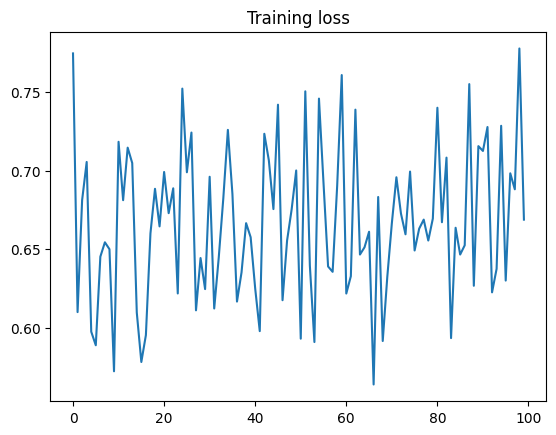

In [23]:
import matplotlib.pyplot as plt

plt.plot(np.arange(rec_loss.shape[0]), rec_loss.mean(axis=-1))
plt.title('Training loss')